* Creator: Nirvan S.P. Theethira
* Date: 04/25/2020
* The file is written to implement and test the class `Geoguessr` in the `geoCNN.py` file. The notebook is used to build the `geoCNN` model and train it on loaded data. Test data can also be loaded using the notebook and the model can be tested.
* Note: This notebook is just used to test training and testing features. Only sample data is available locally for training. The entire dataset is available on drive: https://drive.google.com/drive/folders/1e7RPZEf8-SN9rgsO1oJXE__u04ZEeUXM?usp=sharing

In [1]:
from shapely.geometry import Point, Polygon
from matplotlib import pyplot as plt
from math import sin, cos, sqrt, atan2, radians

# !pip install gmaps
import shapely
import pickle
import random
import numpy as np
import gmaps, os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from ipywidgets.embed import embed_minimal_html
import webbrowser
import geoCNN

# directory containing data
DATADIR = "../infoExtraction/dataSample/imageFilesSample/"
# directory to store model in
MODELDIR = "models"

# change to this when running on google drive/Colab
# DATADIR = '/content/drive/My Drive/geoguessr'
# MODELDIR = '/content/drive/My Drive/geoguessr'

## Load training and testing data

* TF: list of training image file names
* TESF: list of test image file names. 
* File names look like: 0+42.775957,−124.0667758+0−2009−07.jpg

In [2]:
# load training image file names
TF = np.load('../infoExtraction/dataSample/trainFileSample.npy')
# load testing image file names
TESF = np.load('../infoExtraction/dataSample/testFileSample.npy')
print("Train files: {}, Test files: {}".format(len(TF), len(TESF)))

Train files: 15, Test files: 5


* usaPolyGrid: Lists of polygons (list of latitude and longitudes) that represent US map split into grid

243


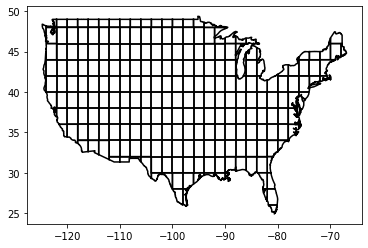

In [3]:
# load split grid file
usaPolyGrid = pickle.load(open("../infoExtraction/usaPolyGrid.pkl",'rb'))
for i in usaPolyGrid.values():
    plt.plot(i[:,1],i[:,0], color='black')
print(len(usaPolyGrid))

## Create and train model
* Parameters that can be set in the cell below
* `hidden1`: number of neurons for first hidden layer
* `hidden2`: number of neurons for the second hidden layer

In [4]:
# model creation and compilation
geoModel = geoCNN.Geoguessr(hidden1=256,hidden2=256)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 10, 19, 2048)      23587712  
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 17, 256)        4718848   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 8, 256)         0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 8, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

Getting data from directory: ../infoExtraction/dataSample/imageFilesSample/
Read 5 points. Training now
Train on 5 samples
Epoch 1/5
5/5 [==============================] - 3s 591ms/sample - loss: 33.8192 - categorical_accuracy: 0.0000e+00
Epoch 2/5
5/5 [==============================] - 1s 216ms/sample - loss: 37.9127 - categorical_accuracy: 0.0000e+00
Epoch 3/5
5/5 [==============================] - 1s 216ms/sample - loss: 22.3473 - categorical_accuracy: 0.4000
Epoch 4/5
5/5 [==============================] - 1s 239ms/sample - loss: 1.2057 - categorical_accuracy: 0.8000
Epoch 5/5
5/5 [==============================] - 1s 217ms/sample - loss: 7.5116 - categorical_accuracy: 0.6000
Training sucessfull!!

Saving model 0 with loss 7.512 at models
Read 5 points. Training now
Train on 5 samples
Epoch 1/5
5/5 [==============================] - 1s 220ms/sample - loss: 16.2919 - categorical_accuracy: 0.0000e+00
Epoch 2/5
5/5 [==============================] - 1s 228ms/sample - loss: 3.4900 - ca

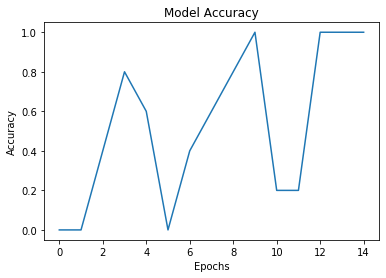

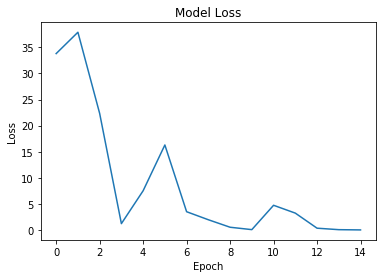

In [5]:
# model training
geoModel.fit(trainFiles = TF, 
      dataDir = DATADIR, 
      saveFolder = MODELDIR,
      epochs=5,
      batchSize=5,
      plot=True
     )

## Load and test single Model
* Make sure the model file name matches the trained and saved model

In [6]:
modelName = '/model_0.083_6mill.h5'
geoModel = geoCNN.Geoguessr.load(MODELDIR + modelName)

Loading model from models/model_0.083_6mill.h5
Loaded model loss 0.083
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 10, 19, 2048)      23587712  
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 17, 256)        4718848   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 8, 256)         0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 8, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
___________________________________________________

* predict on single image

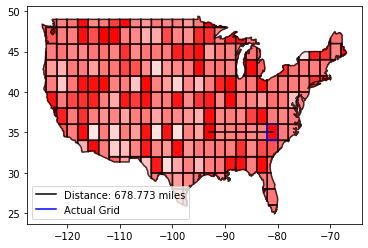

678.7733033827961

In [7]:
geoModel.predictSingle(TESF[0], DATADIR, ployGrid=usaPolyGrid)

* Evaluate entire model on all test data

In [6]:
geoModel.evaluate(TESF, DATADIR, usaPolyGrid)

Evaluated 0 out of 50 points


844.105384136018

## Load and test Multiple Models

In [2]:
models = []
for i in os.listdir(MODELDIR):
    models.append(geoCNN.Geoguessr.load(MODELDIR + '/' +i))

Loading model from models/model_0.025_3mill.h5
Loaded model loss 0.025
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 10, 19, 2048)      23587712  
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 17, 64)         1179712   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 8, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
___________________________________________________

In [34]:
trainableParams = []
avgDistanceError = []
for gm in models:
    trainableParams.append(sum([tf.keras.backend.count_params(i) for i in gm.model.trainable_weights]))
    avgDistanceError.append(gm.evaluate(TESF, DATADIR, usaPolyGrid))

Evaluated 0 out of 50 points
Evaluated 0 out of 50 points
Evaluated 0 out of 50 points
Evaluated 0 out of 50 points


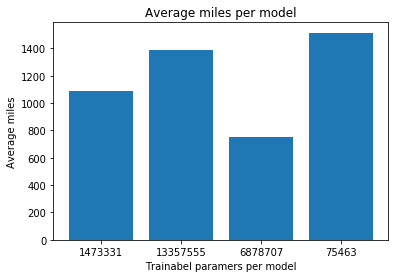

In [36]:
plt.bar(np.arange(len(trainableParams)), height=avgDistanceError)
plt.xticks(np.arange(len(trainableParams)), trainableParams)
plt.xlabel("Trainabel paramers per model")
plt.ylabel("Average miles")
plt.title("Average miles per model")
plt.show()